Проведем АА тест

Количество ложноположительных случаев (FPR) не должно быть больше альфа (5%)

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
path = 'https://raw.githubusercontent.com/Vlkoz/AA-test/main/files/hw_aa.csv'

Считаем данные

In [3]:
df = pd.read_csv(path, sep = ';', index_col=0)

In [4]:
df

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


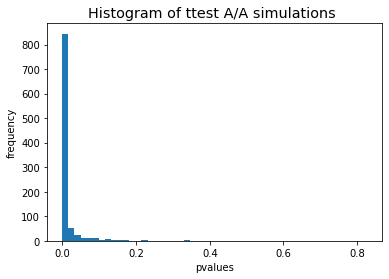

0.924

In [5]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 1] ['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 0] ['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Итак, более чем в 90% АА тесты не сходятся

Необходимо найти причину

Посмотрим на средние значения конверсий по двум группам в разрезе версий приложения

In [7]:
df.query("experimentVariant == 1").groupby('version', as_index=False).agg({'purchase':'mean'})

,version,purchase
0,v2.8.0,0.045606
1,v2.9.0,0.071304
2,v3.7.4.0,0.063018
3,v3.8.0.0,0.062848


In [8]:
df.query("experimentVariant == 0").groupby('version', as_index=False).agg({'purchase':'mean'})

,version,purchase
0,v2.8.0,0.000993
1,v2.9.0,0.074658
2,v3.7.4.0,0.059943
3,v3.8.0.0,0.057604


Конверсии по v2.8.0 сильно различаются между группами

Исключим эту версию из групп и заново проведем АА тест

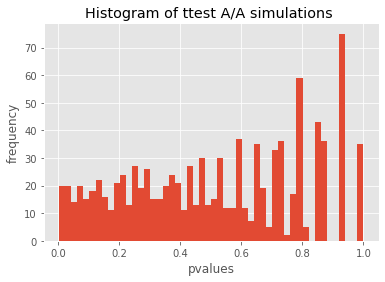

0.044

In [11]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')] ['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')] ['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

АА тест сошелся

Итак, делаем вывод, что загвоздка состоит именно в версии мобильного приложения (v2.8.0),
по которой конверсия в покупку (purchase) в группах значительно различается.